In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/ameshousing/train.csv')

**Load Data**

In [3]:
print('train: ' + str(train.shape))

train: (1460, 81)


Take log on sales price

In [5]:
train.SalePrice = np.log(train.SalePrice + 1)

**Find Most Important Features**

In [6]:
corr = train.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePr

**Build Features**

In [7]:
numerical_features = train.select_dtypes(exclude = [object]).columns
numerical_features = numerical_features.drop('SalePrice')
categorical_features = train.select_dtypes(include = ['object']).columns
print('total_features: %d' % train.shape[1])
print('numerical_features: %d' % len(numerical_features))
print('categorical_features: %d' % len(categorical_features))
train_num = train[numerical_features]

total_features: 81
numerical_features: 37
categorical_features: 43


handle remaining missing values for numerical features by using median as replacement

In [8]:
print('total_null_values: %d' % train_num.isnull().values.sum())
train_num = train_num.fillna(train_num.median())
print('total_null_values: %d' % train_num.isnull().values.sum())

total_null_values: 348
total_null_values: 0


In [9]:
temp_set = train_num
print('temp set dimension: ' + str(temp_set.shape))

temp set dimension: (1460, 37)


**Build Train and Dev Set**

In [12]:
train_set, dev_set, train_set_label, dev_set_label = train_test_split(temp_set, train.SalePrice, test_size=0.3, random_state=0)
print("train set dimension: " + str(train_set.shape))
print("dev set dimension: " + str(dev_set.shape))
print("train set label: " + str(train_set_label.shape))
print("dev set label: " + str(dev_set_label.shape))

train set dimension: (1022, 37)
dev set dimension: (438, 37)
train set label: (1022,)
dev set label: (438,)


**Cost Function**

In [15]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, train_set, train_set_label, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_dev(model):
    rmse= np.sqrt(-cross_val_score(model, dev_set, dev_set_label, scoring = scorer, cv = 10))
    return(rmse)

**Linear Regression**

In [16]:
lr = LinearRegression()
lr.fit(train_set, train_set_label)

print('RMSE at Training Set: %.3f' % rmse_cv_train(lr).mean())
print('RMSE at Dev Set: %.3f' % rmse_cv_dev(lr).mean())

RMSE at Training Set: 0.142
RMSE at Dev Set: 0.184


**Plot Predictions**

In [35]:
train_set_pred = lr.predict(train_set)
dev_set_pred = lr.predict(dev_set)

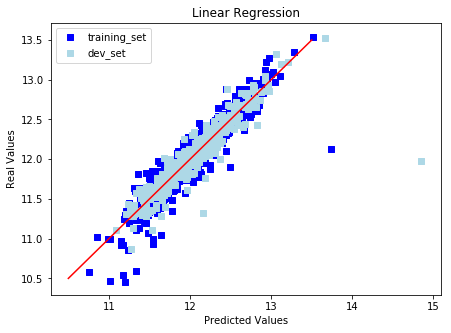

In [40]:
plt.figure(1, figsize=(7, 5))
plt.scatter(train_set_pred, train_set_label, c = "blue", marker = "s", label = "training_set")
plt.scatter(dev_set_pred, dev_set_label, c = "lightblue", marker = "s", label = "dev_set")
plt.title("Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

**XGBoost**

In [26]:
from xgboost import XGBRegressor

In [27]:
xgb = XGBRegressor()

In [28]:
xgb.fit(train_set, train_set_label, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [29]:
print('RMSE at Training Set: %.3f' % rmse_cv_train(xgb).mean())
print('RMSE at Dev Set: %.3f' % rmse_cv_dev(xgb).mean())

RMSE at Training Set: 0.136
RMSE at Dev Set: 0.148


**Plot Predictions**

In [30]:
train_set_pred = xgb.predict(train_set)
dev_set_pred = xgb.predict(dev_set)

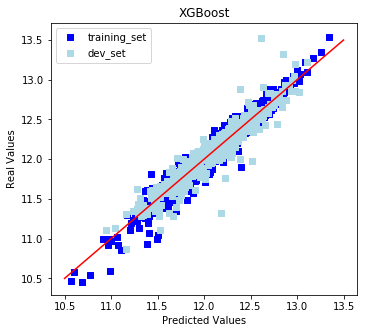

In [32]:
plt.figure(1, figsize=(5.5, 5))
plt.scatter(train_set_pred, train_set_label, c = "blue", marker = "s", label = "training_set")
plt.scatter(dev_set_pred, dev_set_label, c = "lightblue", marker = "s", label = "dev_set")
plt.title("XGBoost")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()